In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from copy import deepcopy

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision.models import vgg19
from torchvision import transforms
import torchvision.transforms.functional as TVF

In [3]:
img_size = (200, 200)
seed = 42
device = "cuda"

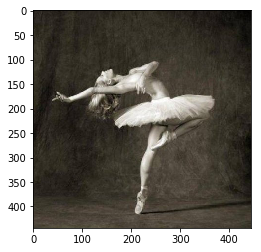

In [4]:
content_img = Image.open("data/content.jpg")
plt.imshow(content_img)
plt.show()

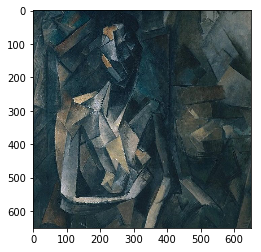

In [5]:
style_img = Image.open("data/style.jpg")
plt.imshow(style_img)
plt.show()

In [6]:
np.random.seed(seed)
opt_image = deepcopy(content_img) # using copy of content image to optimize

# Can use random init image aswell
#opt_image = np.random.uniform(0, 1, size=(img_size[1], img_size[0], 3))

In [7]:
model = vgg19(pretrained='imagenet')
model = model.features.to(device).eval()

for layer in model:
    layer.requires_grad = False

    if isinstance(layer, nn.ReLU):
        layer.inplace = False

In [8]:
# Conv layer before MaxPool
layer_idx = [idx - 2 for idx, layer in enumerate(model)
             if isinstance(layer, nn.MaxPool2d)]
layer_idx

[2, 7, 16, 25, 34]

In [9]:
transform = transforms.Compose(
    [transforms.Resize(img_size),
     transforms.ToTensor()
    ])

In [10]:
content_tensor = transform(content_img)
content_tensor = content_tensor.unsqueeze(0).float().to(device)

style_tensor = transform(style_img)
style_tensor = style_tensor.unsqueeze(0).float().to(device)

opt_tensor = transform(opt_image)
opt_tensor = opt_tensor.unsqueeze(0).float().to(device)
opt_tensor.requires_grad = True

In [11]:
class SaveFeatures:
    features = None

    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = output
    
    def close(self):
        self.hook.remove()

In [12]:
sf_content = SaveFeatures(model[layer_idx[3]])
_ = model(content_tensor)
content_hidden = sf_content.features.clone()

In [13]:
style_hidden = []
sf_style = []

for style_idx in layer_idx:
    sf = SaveFeatures(model[style_idx])
    sf_style.append(sf)
    
    _ = model(style_tensor)
    style_hidden.append(sf.features.clone())

In [14]:
def content_loss_fct(target, pred):
    return F.mse_loss(target, pred, reduction="sum")

def create_gram_matrix(hidden):
    a, b, c, d = hidden.size()
    hidden_features = hidden.view(a*b, c*d)
    hidden_gram = torch.mm(hidden_features, hidden_features.t())
    hidden_gram = hidden_gram / (a*b*c*d)
    return hidden_gram

def style_loss_fct(target, pred):    
    return F.mse_loss(create_gram_matrix(target), 
                      create_gram_matrix(pred), 
                      reduction="sum")

In [15]:
max_iter = 500
content_factor = 1e-7
optimizer = optim.LBFGS([opt_tensor], lr=1.0)

In [16]:
torch.manual_seed(seed)

run = [0]
while run[0] < max_iter:
    def lbfgs_step():
        opt_tensor.data.clamp_(0, 1)        
        optimizer.zero_grad()

        _ = model(opt_tensor)
        opt_hidden = sf_content.features

        content_loss = content_loss_fct(content_hidden, opt_hidden)
        
        style_loss = [style_loss_fct(style_hidden[i], sf_style[i].features.clone())
                      for i in range(len(sf_style))]
        
        content_loss = content_loss * content_factor
        style_loss = sum(style_loss)
        loss = content_loss + style_loss
        loss.backward(retain_graph=True)
        
        run[0] += 1
        if run[0] % 100 == 0:
            print(f"Iteration: {run[0]}")
            print(f"Loss : {loss.detach().cpu().numpy()}")
        return loss
        
    optimizer.step(lbfgs_step)

Iteration: 100
Loss : 0.5615249872207642
Iteration: 200
Loss : 0.4115392565727234
Iteration: 300
Loss : 0.3615208566188812
Iteration: 400
Loss : 0.3357559144496918
Iteration: 500
Loss : 0.3197786211967468


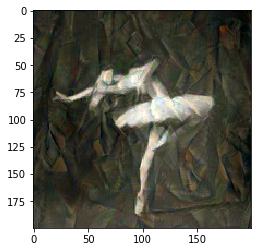

In [17]:
opt_tensor = opt_tensor.clamp(0, 1)
opt_img = opt_tensor.squeeze(0).detach().cpu()
opt_img = TVF.to_pil_image(opt_img)
plt.imshow(opt_img)
plt.show()